# Object Recognition in the modern era
## (And how it differs from object detection)

Object recognition is the term used to refer to the procedure of identifying semantic content from visual data.  This is the process that you perform when I show you a picture, and you tell me what's in it:
<img src="what_am_i.jpg">
Object recognition in the context of *computer vision* is teaching an algorithm to identify what this thing is, usually from a finite set of possibilities.  Note that this is really different from everything that we've been doing up to this point.  We're no longer measuring a physical quantity, but rather asking the algorithm to summarize the contents of an image in order to reduce it to some meaningful statement about its content.  This is also much closer to what we usually think of as "artifical intelligence".  

Note that this task of object recognition is held in contrast to what is called "object detection".  In object detection, we seek to identify the location of an object of interest in an image: Where's Waldo is an example.  Note that these ideas overlap substantially, in the sense that object recognition procedures can be used as a subroutine in object detection, something we'll delve into at the end of this course.  For now, let's concern ourselves with the problem of object recognition.


## The methods
Solutions to this problem are substantially younger than, say, structure from motion.  Indeed, significant progress towards getting a computer to classify an image as 1 in 100 classes wasn't really made until the last decade (arguably two decades).  The reason for this is because this is the time period in which two essential technologies finally matured.  The first is in hardware, namely the availability of extremely powerful Graphical Processing Units (GPUs).  The second ingredient is algorithmic, and it has supplanted essentially every other algorithm used for object recognition (and nearly every other semantic computer vision task): the Convolutional Neural Network.

## CNNs
Many of you have taken Machine Learning, and so you've had an introduction to CNNs already.  **An excellent online resource can be found in the form of Andrew Ng's videos on this subject, found [here](https://youtu.be/ArPaAX_PhIs).  If you're new to CNNs, I suggest that you watch C4W1L01-C4W1L11.  If you've seen this stuff before, you can safely skip the first four lectures.**

First, we should think about what a neural network is, and at a conceptual level it is very simple: a neural network is a function that maps from an input (like an image) to an output (like a classification: hedgehog, rat, chicken, etc.).  It is a very general function, in the sense that it has many parameters that can be tuned in order to make the function behave how we want it to.  In order to tune these parameters, we show the neural network a large number of inputs, and their associated desired outputs (e.g. an image and an animal species), and adjust the parameters so that this mapping generally yields a correct results.  This is a process that you're almost certainly already seen before: regression.    

A CNN is a type of neural network that is designed to work with image data (or anything else where there are a large number of dimensionally ordered inputs, e.g. audio, gene sequences, etc.).  The essence of a CNN is right in the name (convolution), and this is something we've already explored in this course: convolution of an input image with a kernel to produce a so-called *feature map*.  Earlier in the course, we designed kernels in order to produce the results that we wanted.  In particular, we developed a kernel to smooth/blur an image (the Gaussian kernel), a kernel to extract vertical edges (the Sobol-x operator), and one to extract horizontal edges (the Sobol-y operator).  For example, if we apply the Sobol-x operator to the hedgehog above, we get the following feature map

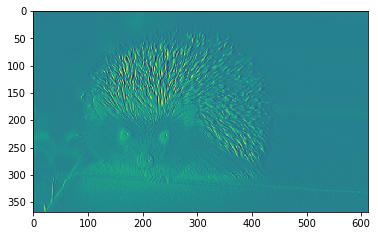

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssig

hedgehog = plt.imread('what_am_i.jpg')
hedgehog = hedgehog.mean(axis=2)

sobol_x = np.array([[-1,0,1],
                    [-2,0,1],
                    [-1,0,1]])

fmap_sobol_x = ssig.convolve2d(hedgehog,sobol_x,mode='valid')
plt.imshow(fmap_sobol_x)
plt.show()

In a convolutional network, we are taking many of these filters and applying them to an input, then running the result through a non-linear function called an *activation*, for example a sigmoid, or a rectified linear unit.  So, the first layer of a CNN might look like this, if we were using the three kernels mentioned above:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


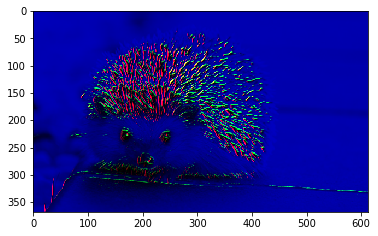

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssig

hedgehog = plt.imread('what_am_i.jpg')
hedgehog = hedgehog.mean(axis=2)/255.

def relu(X):
    return np.maximum(X,0)

sobol_x = 1.0*np.array([[-1,0,1],
                    [-2,0,1],
                    [-1,0,1]])

sobol_y = sobol_x.T

gauss = 1./8*np.array([[0,1,0],
                       [1,2,1],
                       [0,1,0]])

fmap_sobol_x = ssig.convolve2d(hedgehog,sobol_x,mode='valid')
fmap_sobol_y = ssig.convolve2d(hedgehog,sobol_y,mode='valid')
fmap_gauss = ssig.convolve2d(hedgehog,gauss,mode='valid')

y = relu(np.dstack((fmap_sobol_x,fmap_sobol_y,fmap_gauss)))

plt.imshow(y)
plt.show()

Displaying a false color image of the resulting feature maps, we can see that things like the hedghog quills are highlighted.  Perhaps this transformation of the input can help us in determining what this creature is?  There are few other animals which would yield such a pattern.  This is the fundamental utility of the convolutional part of the neural network: to non-linearly transform the inputs into something that is more easily interpreted as the object that it is.  

How is this a type of neural network?  In the case of a CNN, the coefficients of the kernels are tunable parameters.  Thus, if highlighting vertical lines in the image were to help the neural network correctly classify the image as a hedgehog, then perhaps it would learn some approximation to the Sobol-x kernel.  

## Implementation of a CNN in Keras
In years past implementation of neural networks, particularly large and challenging ones like CNNs often are, was a substantial endeavour.  However, nowadays, with these things being utilized in all sorts of ways, there exists excellent software libraries that largely abstract away these difficulties.  One such library is called [Keras](https://keras.io/), which provides a convenient API for generating all sorts of neural networks, including convolutional ones.  It sits atop another excellent piece of software, called [Tensorflow](https://www.tensorflow.org/), which is a general framework for computation on graphs.  

**For our further exercises, you'll want to install tensorflow and keras on your computer.**  If possible, install it with GPU support, although this can be a difficult process: for more challenging computation, I will be providing you with SSH access to a machine with a large GPU that has these libraries installed already.  However, for our first simple examples that we will use here, it will not really be needed.

As a first example, we'll apply a neural network to the CIFAR-10 dataset, which contains 60000 32x32x3 images, each of which contains an object in one of 10 classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.  We seek to develop a neural network that can, given a new input image, successfully classify the image into one of these categories.